In [3]:
# imports
import plotly.express as px 
import pandas as pd 
import numpy as np 
import pandas as pd
import scipy.stats as stats

### Импортируем данные

In [15]:
df = pd.read_csv('test_data.csv')

In [16]:
df

,ms,cohort,user_cnt,gross
0,ORGANIC,2016-01-01,3676,1510
1,UA,2016-01-01,6061,686
2,UA,2016-01-02,6542,1179
3,ORGANIC,2016-01-02,3875,565
4,ORGANIC,2016-01-03,3699,425
...,...,...,...,...
1457,UA,2017-12-29,4180,65
1458,ORGANIC,2017-12-30,5651,17
1459,UA,2017-12-30,4291,13
1460,UA,2017-12-31,3743,25


# 1. Подсчет k-factor'а для трафовых пользователей

### Построим график cohort от user_cnt

In [230]:
fig = px.line(df, x='cohort', y='user_cnt', color='ms')

# Show plot 
fig.show()

### На графике определенно можно заметить некоторую взаимосвязь между ростом числа трафовых и числа органических пользователей

### Построим графики распределения user_cnt UA и ORGANIC, чтобы выяснить их вид распределения

In [149]:
table = pd.pivot_table(df, values='user_cnt', index=['cohort'],
                    columns=['ms'], aggfunc=np.sum)

<AxesSubplot:>

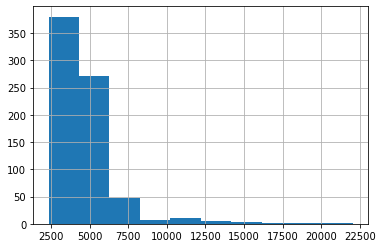

In [126]:
table.ORGANIC.hist()

<AxesSubplot:>

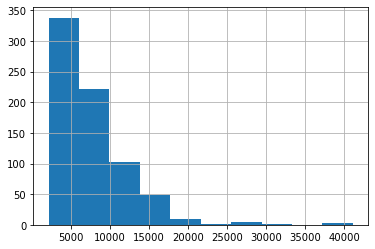

In [127]:
table.UA.hist()

### На графиках видно, что user_cnt ненормально распределены. Поэтому для оценки корелляции между ними не стоит применять коэффициент Пирсона. Используем для этой цели ранговый коэффициент Спирмена. Но перед оценкой корелляции сначала посмотрим на график зависимости UA от ORGANIC на предмет статистических выбросов

In [153]:

fig = px.scatter(table, x='UA', y='ORGANIC')

# Show plot 
fig.show()

###  На графике заметен линейный тренд. А еще заметно выделяются статистические выбросы ORGANIC, которые очевидно стоит рассмотреть отдельно, но для будущего регрессионного анализа их стоит отфильтровать. Поэтому уберем верхний 5% процентиль.

In [161]:
upper_bound = table['ORGANIC'].quantile(q=0.95)
table_filtered = table[(table['ORGANIC'] < upper_bound)]

### Оценим корелляцию с помощью коэффициента Спирмена

In [162]:
table_filtered.corr('spearman')

ms,ORGANIC,UA
ms,,
ORGANIC,1.000000,0.673576
UA,0.673576,1.000000


### Значение коэффициента указывает на достаточно сильную корреляцию. Более того, на графике зависимости user_cnt ORGANIC от user_cnt UA наблюдался линейный тренд. Поэтому для вычисления зависимости между ними используем линейную регрессию

In [164]:
import scipy.stats as sps

n = len(table_filtered['UA'])
lin_model = sps.linregress(table_filtered['UA'].values, table_filtered['ORGANIC'].values)
a,b = lin_model.slope, lin_model.intercept
# оценка ср.кв. ошибки для a и b
a_err, b_err = lin_model.stderr, lin_model.intercept_stderr
# Доверительный интервал для alpha=5%
a_conf = sps.t.interval(0.95, df = n-2, loc=a, scale=a_err)
b_conf = sps.t.interval(0.95, df = n-2, loc=b, scale=b_err)

print(f"a = {a:0.4f}, α=5% [{a_conf[0]:0.4f} - {a_conf[1]:0.4f}]")
print(f"b = {b:0.4f}, α=5% [{b_conf[0]:0.4f} - {b_conf[1]:0.4f}]")

a = 0.2011, α=5% [0.1864 - 0.2158]
b = 2849.4549, α=5% [2728.5363 - 2970.3736]


# Результат: каждый трафовый пользователь приводит в среднем 0.2 "виральных" пользователя. Доверительный интервал k-factor'a - [0.186 - 0.216]

# 2. Вычислить k-factor для денег

### Построим графики распределения гроссов

In [169]:
table = pd.pivot_table(df, values='gross', index=['cohort'],
                    columns=['ms'], aggfunc=np.sum)

<AxesSubplot:>

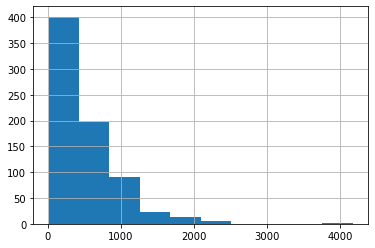

In [170]:
table.UA.hist()

<AxesSubplot:>

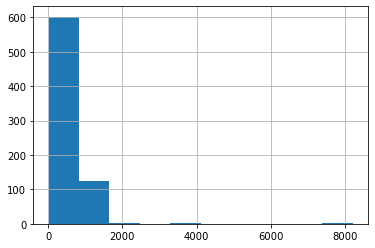

In [171]:
table.ORGANIC.hist()

### Снова видим, что гистограммы не похожи на нормальное распределение. Значит корреляцию придется измерять с помощью коэффициента Спирмана. Построим теперь график зависимости гросса бесплатных пользователей от гросса платных

In [172]:

fig = px.scatter(table, x='UA', y='ORGANIC')

# Show plot 
fig.show()

### На графике снова наблюдаются статистические выбросы, но они незначительные. Более того, снова заметен линейный тренд. Посчитаем коэффициент корреляции

In [184]:
table.corr('spearman')

ms,ORGANIC,UA
ms,,
ORGANIC,1.000000,0.584476
UA,0.584476,1.000000


### Корелляция не такая сильная, как в случае с пользователями. Тем не менее, она всё равно достаточно значительная, поэтому попробуем применить регрессионный анализ и в этом случае

In [185]:
import scipy.stats as sps

n = len(table_filtered.UA)
lin_model = sps.linregress(table_filtered.UA.values, table_filtered.ORGANIC.values)
a,b = lin_model.slope, lin_model.intercept
# оценка ср.кв. ошибки для a и b
a_err, b_err = lin_model.stderr, lin_model.intercept_stderr
# Доверительный интервал для alpha=5%
a_conf = sps.t.interval(0.95, df = n-2, loc=a, scale=a_err)
b_conf = sps.t.interval(0.95, df = n-2, loc=b, scale=b_err)

print(f"a = {a:0.4f}, α=5% [{a_conf[0]:0.4f} - {a_conf[1]:0.4f}]")
print(f"b = {b:0.4f}, α=5% [{b_conf[0]:0.4f} - {b_conf[1]:0.4f}]")

a = 0.3444, α=5% [0.2980 - 0.3908]
b = 331.7524, α=5% [300.9139 - 362.5910]


# Результат: каждый доллар трафового пользователя привлекает примерно 0.34 доллара из-за виральности. Доверительный интервал [0.298 - 0.391]

In [190]:
fig = px.scatter(df.loc[df['ms'] == 'UA'], x='user_cnt', y='gross')

# Show plot 
fig.show()

# Дополнительный анализ данных

### Построим для начала общие графики гросса и инсталлов для каждой когорты

In [194]:
fig = px.line(df, x='cohort', y='gross', color='ms')

# Show plot 
fig.show()

In [195]:
fig = px.line(df.loc[df['ms'] == 'ORGANIC'], x='cohort', y='user_cnt', color='ms')

# Show plot 
fig.show()

### Заметно, что пики инсталлов органики не всегда совпадают с пиками гросса. Я бы проверил пользователей из когорт пиковых дней на предмет читов

### Анализ автокорреляции

In [231]:
table = pd.pivot_table(df, values='gross', index=['cohort'],
                    columns=['ms'], aggfunc=np.sum)

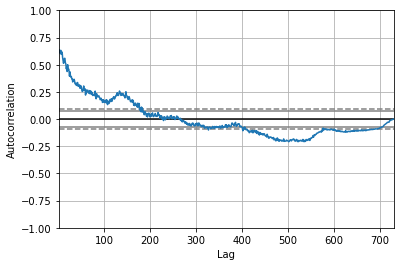

In [232]:
x = pd.plotting.autocorrelation_plot(table[['UA']])

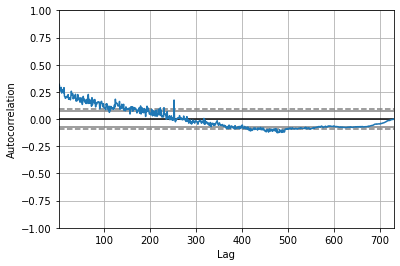

In [233]:
x = pd.plotting.autocorrelation_plot(table[['ORGANIC']])

In [239]:
table = pd.pivot_table(df, values='user_cnt', index=['cohort'],
                    columns=['ms'], aggfunc=np.sum)

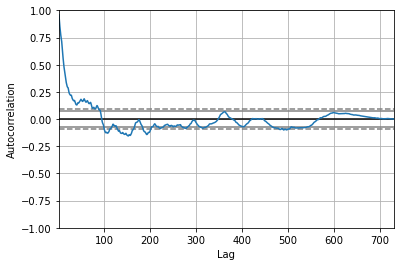

In [240]:
x = pd.plotting.autocorrelation_plot(table[['UA']])

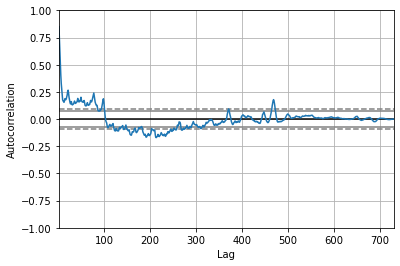

In [241]:
x = pd.plotting.autocorrelation_plot(table[['ORGANIC']])

### Анализ синхронности UA и ORGANIC

In [242]:
table = pd.pivot_table(df, values='gross', index=['cohort'],
                    columns=['ms'], aggfunc=np.sum)

In [243]:
table

ms,ORGANIC,UA
cohort,,
2016-01-01,1510,686
2016-01-02,565,1179
2016-01-03,425,1186
2016-01-04,1161,718
2016-01-05,917,1308
...,...,...
2017-12-27,46,146
2017-12-28,32,89
2017-12-29,61,65


### Анализ синхронности

In [248]:
from scipy.stats import spearmanr

In [252]:
synch = 0
for i in range(0, 50):
    if i == 0:
        max_corr, p = spearmanr(list(df.loc[df.ms == 'UA'].gross), list(df.loc[df.ms != 'UA'].gross))
    else:
        corr, p = spearmanr(list(df.loc[df.ms == 'UA'].gross[:-i]), list(df.loc[df.ms != 'UA'].gross[i:]))
        if corr > max_corr:
            max_corr = corr
            synch = i
            

In [251]:
synch

0

In [253]:
synch = 0
for i in range(0, 50):
    if i == 0:
        max_corr, p = spearmanr(list(df.loc[df.ms == 'UA'].user_cnt), list(df.loc[df.ms != 'UA'].user_cnt))
    else:
        corr, p = spearmanr(list(df.loc[df.ms == 'UA'].user_cnt[:-i]), list(df.loc[df.ms != 'UA'].user_cnt[i:]))
        if corr > max_corr:
            max_corr = corr
            synch = i
            

In [254]:
synch

0